# Workflow

1. Import and Preprocessing
2. Dataset exploration
3. Co-occurrence matrix construction
4. Graph
5. Plots
6. Report

<a id="loadlibraries"></a>
# `Load Libraries`
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
print("Loading dataset...")
df = pd.read_csv("02_terms.csv")
df.head()
# each row is a document. Binary values indicate if there are in the document or not

Loading dataset...


,DocNumber,advice,author,cold,computing,encourage,examples,information,help,lesson,...,positions,proposal,recommend,research,sentiment,slides,suggestion,tip,tutorial,users
0,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,3,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
4,5,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [63]:
print("\n--- Dataset Overview ---")
print("Shape:", df.shape)
print("Column types:\n", df.dtypes)
print("\nFirst 5 rows:")
print(df.head())



--- Dataset Overview ---
Shape: (153, 22)
Column types:
 DocNumber      int64
advice         int64
author         int64
cold           int64
computing      int64
encourage      int64
examples       int64
information    int64
help           int64
lesson         int64
news           int64
opinion        int64
positions      int64
proposal       int64
recommend      int64
research       int64
sentiment      int64
slides         int64
suggestion     int64
tip            int64
tutorial       int64
users          int64
dtype: object

First 5 rows:
   DocNumber  advice  author  cold  computing  encourage  examples  \
0          1       0       0     0          0          1         0   
1          2       0       0     0          0          1         0   
2          3       0       0     0          1          0         0   
3          4       0       0     0          1          0         0   
4          5       0       0     0          0          1         0   

   information  help  lesson  

In [64]:
df.columns

Index(['DocNumber', 'advice', 'author', 'cold', 'computing', 'encourage',
       'examples', 'information', 'help', 'lesson', 'news', 'opinion',
       'positions', 'proposal', 'recommend', 'research', 'sentiment', 'slides',
       'suggestion', 'tip', 'tutorial', 'users'],
      dtype='object')

In [77]:
print("\n--- Data Preprocessing ---")
# Transform to long format for easier analysis
df_long = df.melt(id_vars=['DocNumber'], 
                  var_name='term', 
                  value_name='frequency')
# Rename columns for clarity
df_long.columns = ['document_id', 'term', 'frequency']

# Remove rows with frequency zero (term not present)
df_long = df_long[df_long['frequency'] > 0]

# Reset index
df_long.reset_index(drop=True, inplace=True)

df_long.head()




--- Data Preprocessing ---


,document_id,term,frequency
0,16,advice,1
1,18,advice,1
2,19,advice,1
3,20,advice,1
4,21,advice,1


In [66]:
# Display information about the transformed data
print("Transformed data (first 5 rows):")
print(df_long.head())
print("\n➡️ Total number of rows:", df_long.shape[0])
print("➡️ Number of documents:", df_long['document_id'].nunique())
print("➡️ Number of terms:", df_long['term'].nunique())
print("➡️ Null values:", df_long.isnull().sum().sum())


Transformed data (first 5 rows):
   document_id    term  frequency
0           16  advice          1
1           18  advice          1
2           19  advice          1
3           20  advice          1
4           21  advice          1

➡️ Total number of rows: 400
➡️ Number of documents: 139
➡️ Number of terms: 21
➡️ Null values: 0



--- Data Exploration ---

4.1 Term Frequency Analysis
Top 10 most frequent terms:
term
recommend    69
encourage    52
help         46
advice       23
news         20
lesson       17
users        17
examples     17
slides       16
tutorial     16
Name: frequency, dtype: int64


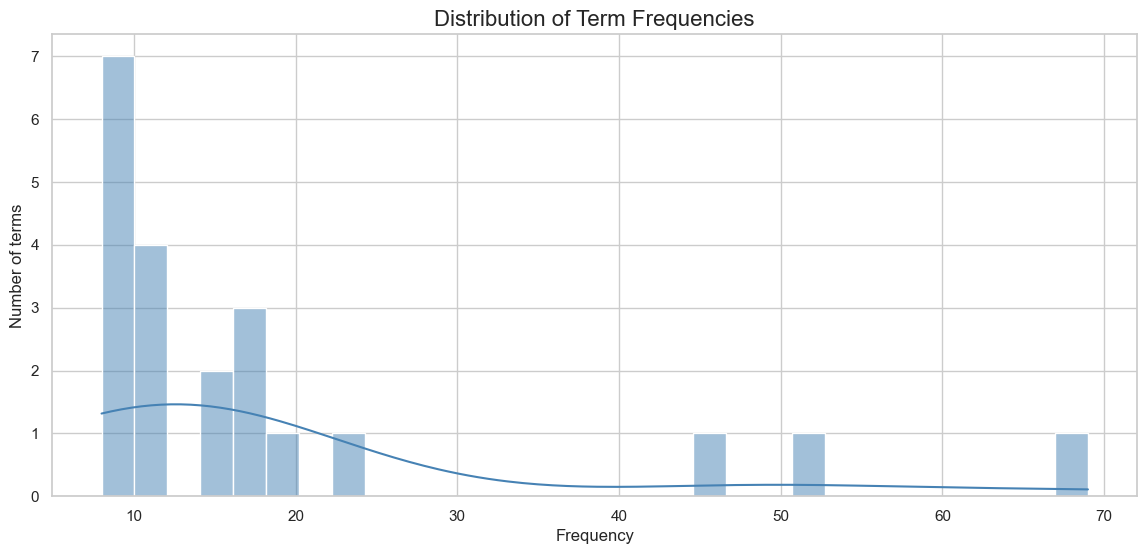

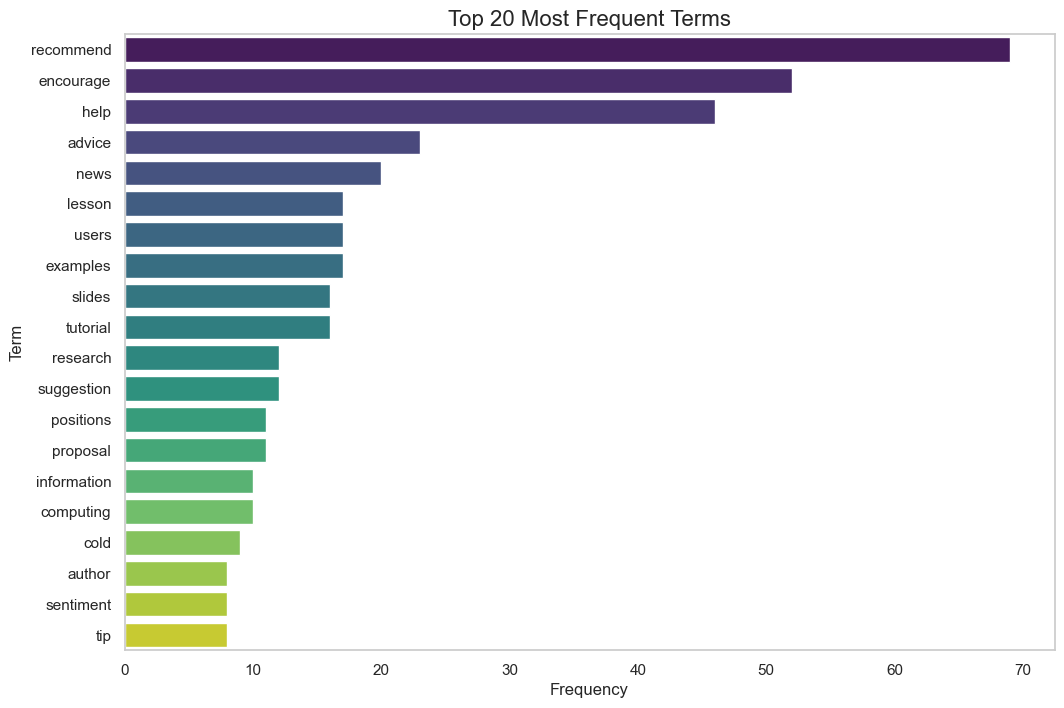

In [ ]:
print("\n--- Data Exploration ---")

# 4.1 Term frequency analysis
print("\nTerm Frequency Analysis")
# Calculate term frequencies across all documents
term_freq = df_long.groupby('term')['frequency'].sum().sort_values(ascending=False)

# Display top terms
print("Top 10 most frequent terms:")
print(term_freq.head(10))

# Create histogram of term frequencies
plt.figure(figsize=(14, 6))
sns.histplot(term_freq, bins=30, kde=True, color='steelblue')
plt.title('Distribution of Term Frequencies', fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('Number of terms')
plt.grid(True)
plt.show()
plt.close()

# Create bar chart for top terms
top_terms = term_freq.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_terms.values, y=top_terms.index, palette='viridis')
plt.title('Top 20 Most Frequent Terms', fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('Term')
plt.grid(axis='x')
plt.show()
plt.close()


4.2 Document Analysis
Documents with the most terms:
document_id
108    7
126    7
4      6
121    6
94     6
128    6
136    6
12     6
27     5
24     5
dtype: int64


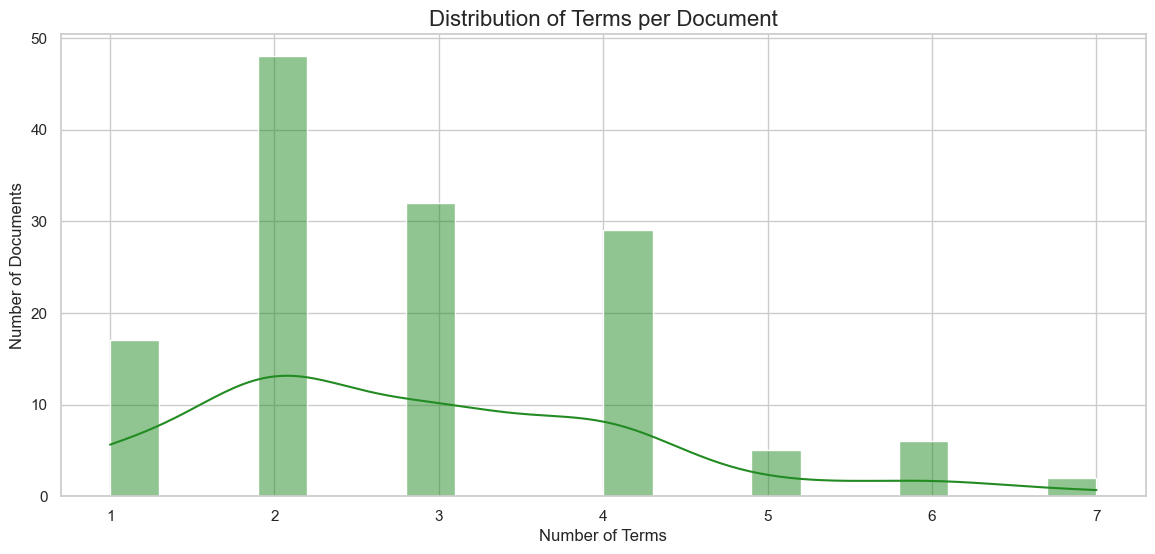

In [82]:
# 4.2 Document analysis
print("\n4.2 Document Analysis")
# Count terms per document
doc_term_count = df_long.groupby('document_id').size().sort_values(ascending=False)
print("Documents with the most terms:")
print(doc_term_count.head(10))

# Create histogram of terms per document
plt.figure(figsize=(14, 6))
sns.histplot(doc_term_count, bins=20, kde=True, color='forestgreen')
plt.title('Distribution of Terms per Document', fontsize=16)
plt.xlabel('Number of Terms')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()
plt.close()


In [ ]:
# 4.3 Document-Term relationship
print("\nDocument-Term Relationship")
# Create a pivot table to see which documents contain which terms
doc_term_pivot = df_long.pivot_table(
    index='document_id', 
    columns='term', 
    values='frequency', 
    aggfunc='sum',
    fill_value=0
)

# Answer: Which document has the most terms?
max_terms_doc = doc_term_count.idxmax()
max_terms_count = doc_term_count.max()
print(f"Document with the most terms: Document {max_terms_doc} with {max_terms_count} terms.")



4.3 Document-Term Relationship
Document with the most terms: Document 108 with 7 terms.


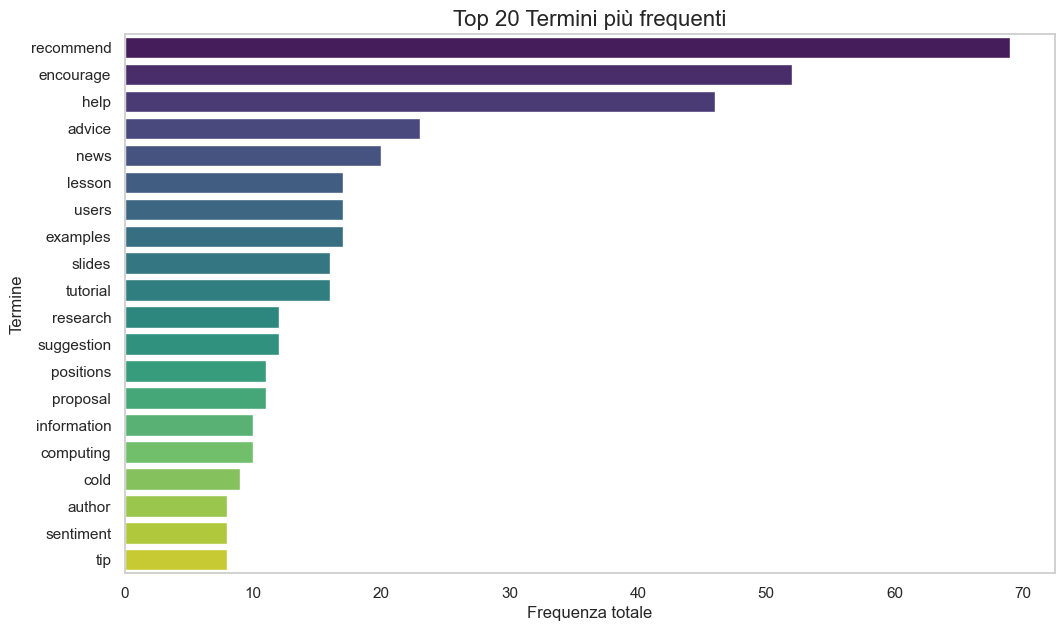

In [70]:
top_terms = term_freq.head(20)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_terms.values, y=top_terms.index, palette='viridis')
plt.title('Top 20 Termini più frequenti', fontsize=16)
plt.xlabel('Frequenza totale')
plt.ylabel('Termine')
plt.grid(axis='x')
plt.show()


In [71]:
# 5. Co-occurrence Analysis
print("\n--- Co-occurrence Analysis ---")
# Group by document to get list of terms in each document
doc_term_map = df_long.groupby('document_id')['term'].apply(list)

# Calculate term co-occurrences
co_occurrence = Counter()
for terms in doc_term_map:
    # Use set to avoid counting duplicates within the same document
    pairs = combinations(set(terms), 2)
    co_occurrence.update(pairs)

# Convert to DataFrame
co_df = pd.DataFrame(co_occurrence.items(), columns=['pair', 'count'])
co_df[['term1', 'term2']] = pd.DataFrame(co_df['pair'].tolist(), index=co_df.index)
co_df.drop(columns=['pair'], inplace=True)
co_df = co_df[['term1', 'term2', 'count']]

# Display the strongest co-occurrences
print("Top 10 strongest term co-occurrences:")
print(co_df.sort_values(by='count', ascending=False).head(10))

# Find least connected terms
if co_df['count'].min() == 0:
    least_connected = co_df[co_df['count'] == 0].head(5)
else:
    least_connected = co_df.sort_values(by='count').head(5)
    
print("\nLeast connected term pairs:")
print(least_connected)


--- Co-occurrence Analysis ---
Top 10 strongest term co-occurrences:
        term1       term2  count
33       help   encourage     33
22  recommend   encourage     21
32       help   recommend     18
14       news   recommend     14
75   examples   recommend     14
19      users   recommend      9
38     advice  suggestion      9
4   computing   recommend      9
27  recommend      slides      8
50  recommend      advice      7

Least connected term pairs:
           term1     term2  count
158     tutorial      cold      1
44        advice     users      1
45        lesson     users      1
106  information  tutorial      1
122         news    slides      1


In [ ]:
# 6. Network Graph Analysis
print("\n--- Network Graph Analysis ---")

# 6.1 Create Graph
print("\nCreating Term Network Graph")
G = nx.Graph()

# Add nodes (terms)
terms = pd.unique(co_df[['term1', 'term2']].values.ravel('K'))
G.add_nodes_from(terms)

# Add edges (co-occurrences)
for _, row in co_df.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['count'])

print(f"✅ Nodes in graph: {G.number_of_nodes()}")
print(f"✅ Edges in graph: {G.number_of_edges()}")

# 6.2 Calculate Network Metrics
print("\n6.2 Calculating Network Metrics")
# Degree centrality
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_centrality, 'betweenness')

# Display top terms by centrality
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("🔝 Top 10 terms by degree centrality:")
for term, score in top_degree:
    print(f"{term:<15} | {score:.3f}")

top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\n🔝 Top 10 terms by betweenness centrality:")
for term, score in top_betweenness:
    print(f"{term:<15} | {score:.3f}")

# 6.3 Community Detection
print("\n6.3 Community Detection")
from networkx.algorithms.community import greedy_modularity_communities

# Find communities
communities = list(greedy_modularity_communities(G))
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Assign communities to nodes
nx.set_node_attributes(G, community_map, 'community')
print(f"🎯 Number of communities detected: {len(communities)}")

# Display communities
print("\nCommunities:")
for i, community in enumerate(communities):
    print(f"Community {i}: {', '.join(sorted(list(community)))}")


--- Network Graph Analysis ---

6.1 Creating Term Network Graph
✅ Nodes in graph: 21
✅ Edges in graph: 128

6.2 Calculating Network Metrics
🔝 Top 10 terms by degree centrality:
help            | 1.000
encourage       | 0.900
recommend       | 0.850
advice          | 0.850
tutorial        | 0.800
slides          | 0.750
users           | 0.700
lesson          | 0.700
examples        | 0.700
news            | 0.600

🔝 Top 10 terms by betweenness centrality:
help            | 0.096
encourage       | 0.082
recommend       | 0.049
advice          | 0.044
lesson          | 0.029
tutorial        | 0.025
slides          | 0.019
suggestion      | 0.014
users           | 0.013
research        | 0.013

6.3 Community Detection
🎯 Number of communities detected: 3

Communities:
Community 0: advice, author, encourage, help, lesson, positions, proposal, research, suggestion
Community 1: computing, news, opinion, recommend, slides, tutorial, users
Community 2: cold, examples, information, sentiment, t

In [ ]:
# 7. Visualization
print("\n--- Visualizations ---")

# 7.1 Network graph visualization
print("\nNetwork Graph Visualization")
plt.figure(figsize=(16, 12))

# Set node positions using spring layout
layout = nx.spring_layout(G, seed=42, k=0.5)

# Color nodes by community
colors = [community_map[node] for node in G.nodes()]

# Size nodes by degree centrality
sizes = [5000 * degree_centrality[node] for node in G.nodes()]

# Draw nodes
nx.draw_networkx_nodes(G, layout,
                       node_color=colors,
                       node_size=sizes,
                       cmap=plt.cm.Set2,
                       alpha=0.8)

# Draw edges with width based on weight
edge_weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
nx.draw_networkx_edges(G, layout, 
                       width=edge_weights,
                       edge_color='lightgray', 
                       alpha=0.4)

# Draw labels
nx.draw_networkx_labels(G, layout,
                        font_size=10,
                        font_family='sans-serif')

plt.title("Term Co-occurrence Network", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.savefig('term_network.png', dpi=300, bbox_inches='tight')
plt.close()


--- Visualizations ---

7.1 Network Graph Visualization



7.2 Co-occurrence Heatmap


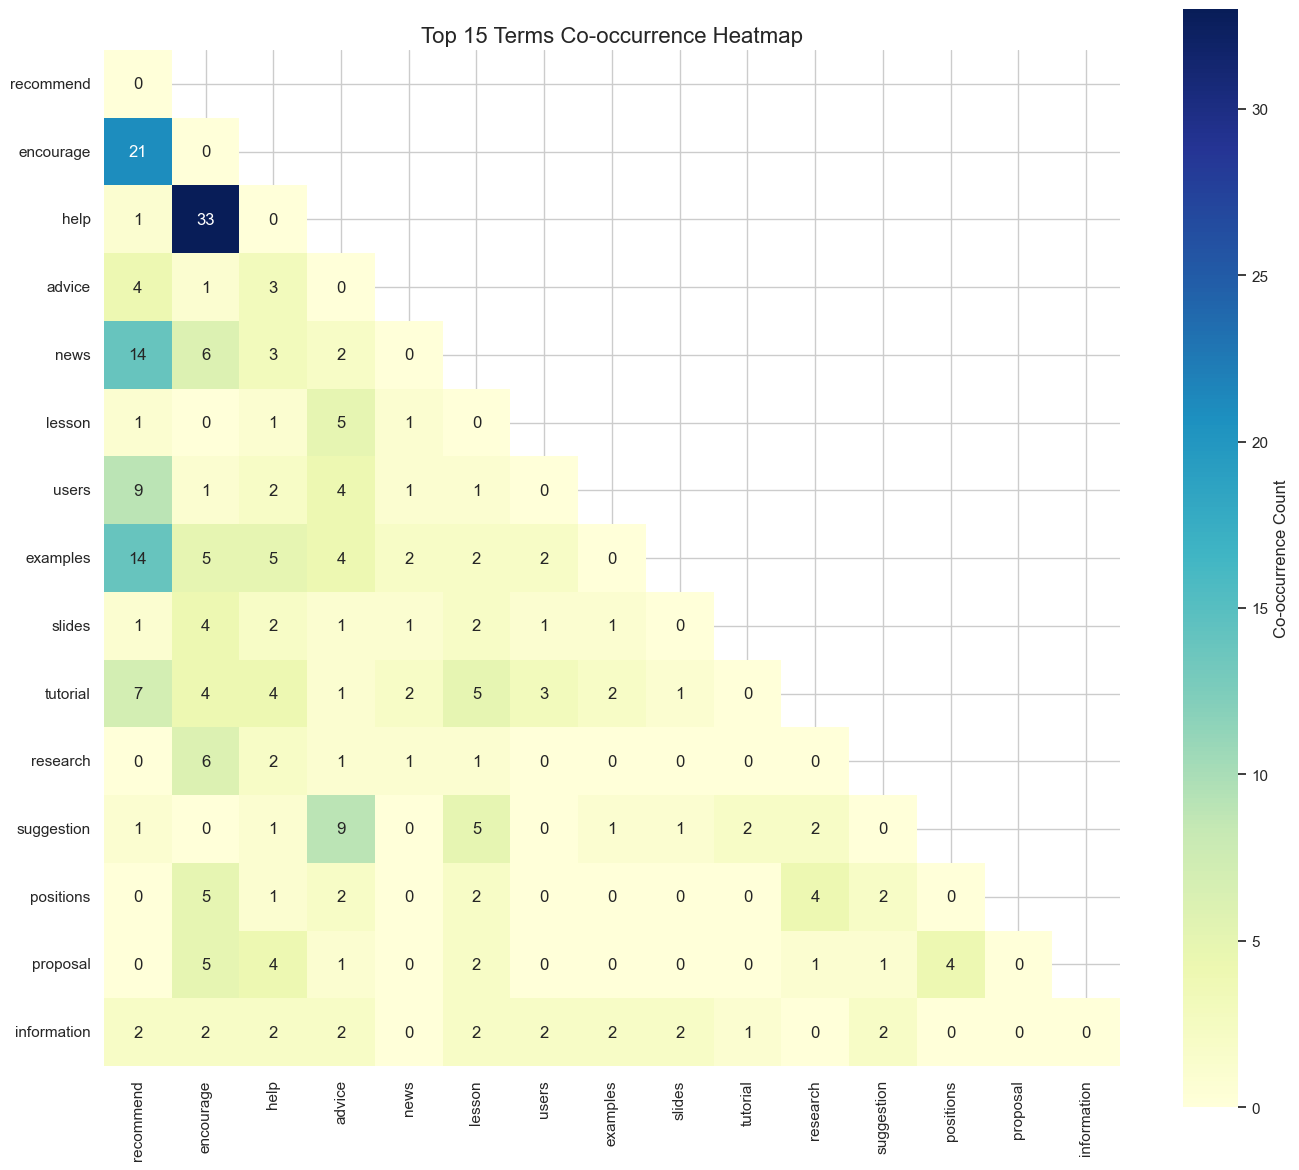


7.3 Top Terms Network Visualization


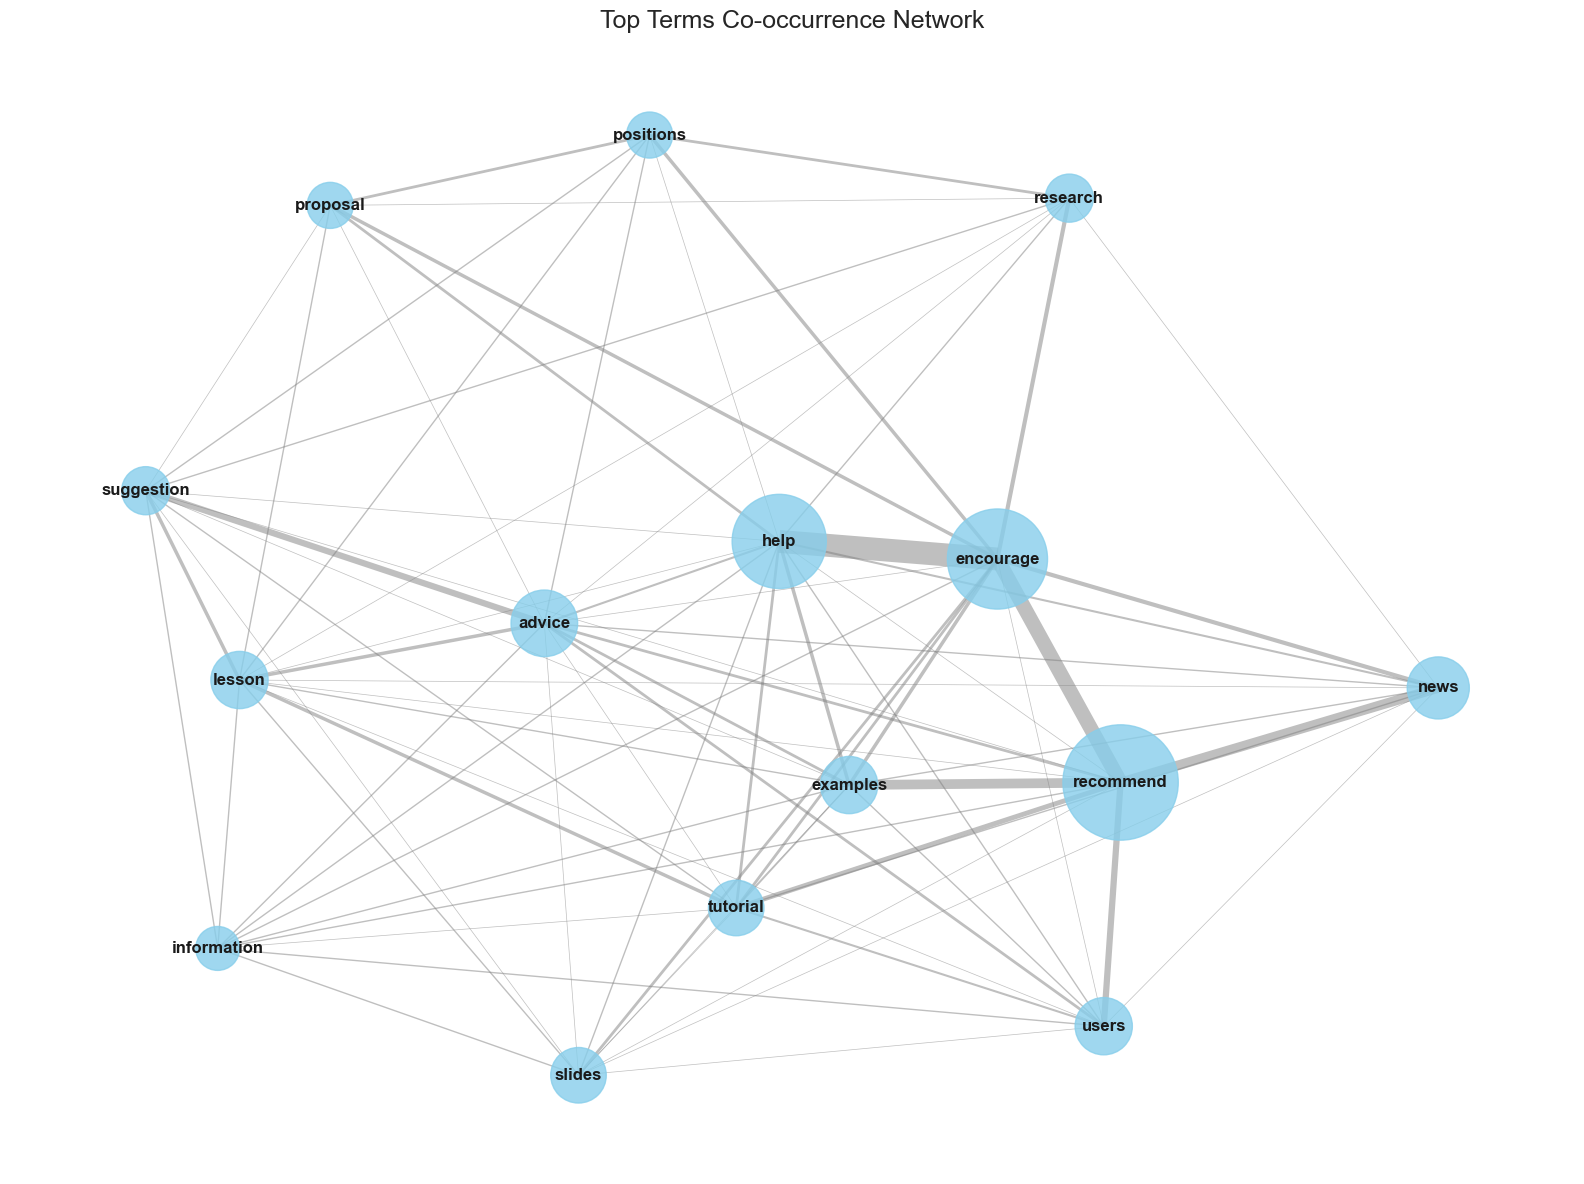

In [ ]:
# 7.2 Alternative approach for co-occurrence heatmap
print("\nCo-occurrence Heatmap")

# Get top N terms by frequency
top_n_terms = 15
top_terms_list = term_freq.head(top_n_terms).index.tolist()

# Create an empty square matrix for co-occurrences
co_matrix = np.zeros((top_n_terms, top_n_terms))

# Create a dictionary for fast lookup
term_to_index = {term: i for i, term in enumerate(top_terms_list)}

# Fill the matrix with co-occurrence counts
for _, row in co_df.iterrows():
    term1, term2 = row['term1'], row['term2']
    count = row['count']
    
    # Check if both terms are in our top terms list
    if term1 in term_to_index and term2 in term_to_index:
        i = term_to_index[term1]
        j = term_to_index[term2]
        co_matrix[i, j] = count
        co_matrix[j, i] = count  # Make it symmetric

# Create a DataFrame from the matrix
co_matrix_df = pd.DataFrame(co_matrix, index=top_terms_list, columns=top_terms_list)

# Plot heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(co_matrix_df, dtype=bool), k=1)  # Mask for lower triangular
sns.heatmap(
    co_matrix_df, 
    annot=True, 
    fmt='.0f',
    cmap='YlGnBu',
    mask=mask,  # Optional: use only lower triangle due to symmetry
    square=True,
    cbar_kws={'label': 'Co-occurrence Count'}
)
plt.title(f'Top {top_n_terms} Terms Co-occurrence Heatmap', fontsize=16)
plt.tight_layout()
plt.savefig('co_occurrence_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()  # Add explicit show() to ensure it's displayed
plt.close()

# Alternative visualization: Network graph of top terms only
print("\nTop Terms Network Visualization")
G_top = nx.Graph()

# Add top terms as nodes
for term in top_terms_list:
    G_top.add_node(term)

# Add edges for co-occurrences
for term1_idx, term1 in enumerate(top_terms_list):
    for term2_idx, term2 in enumerate(top_terms_list):
        if term1_idx < term2_idx:  # Avoid duplicates
            weight = co_matrix_df.loc[term1, term2]
            if weight > 0:
                G_top.add_edge(term1, term2, weight=weight)

# Set node positions
pos = nx.spring_layout(G_top, seed=42)

# Plot the graph
plt.figure(figsize=(16, 12))

# Draw nodes with size based on frequency
node_sizes = [term_freq[term] * 100 for term in top_terms_list]
nx.draw_networkx_nodes(G_top, pos, node_color='skyblue', 
                      node_size=node_sizes, alpha=0.8)

# Draw edges with width based on co-occurrence count
edge_weights = [G_top[u][v]['weight'] * 0.5 for u, v in G_top.edges()]
nx.draw_networkx_edges(G_top, pos, width=edge_weights, 
                      alpha=0.5, edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G_top, pos, font_size=12, font_weight='bold')

plt.title("Top Terms Co-occurrence Network", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.savefig('top_terms_network.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [89]:
# 8. Summary of Findings
print("\n ---Summary of Findings ---")
print("\nMost Important Terms")
print(f"    The most frequent term is '{term_freq.index[0]}' with {term_freq.iloc[0]} occurrences.")
print(f"    The most central term (by degree) is '{top_degree[0][0]}' with score {top_degree[0][1]:.3f}.")
print(f"    The most central term (by betweenness) is '{top_betweenness[0][0]}' with score {top_betweenness[0][1]:.3f}.")

print("\nTerm Relationships")
strongest_connection = co_df.sort_values(by='count', ascending=False).iloc[0]
print(f"    The strongest connection is between '{strongest_connection['term1']}' and '{strongest_connection['term2']}' with {strongest_connection['count']} co-occurrences.")

weakest_connection = co_df[co_df['count'] > 0].sort_values(by='count').iloc[0]
print(f"    The weakest connection is between '{weakest_connection['term1']}' and '{weakest_connection['term2']}' with only {weakest_connection['count']} co-occurrence.")

print("\nCommunity Structure")
print(f"    The network has {len(communities)} communities, suggesting distinct clusters of related terms.")
largest_community = max(communities, key=len)
print(f"    The largest community has {len(largest_community)} terms.")

print("\nDocument Analysis")
print(f"    Document {max_terms_doc} has the most terms ({max_terms_count}).")
print(f"    The average document contains {doc_term_count.mean():.2f} unique terms.")



 ---Summary of Findings ---

Most Important Terms
    The most frequent term is 'recommend' with 69 occurrences.
    The most central term (by degree) is 'help' with score 1.000.
    The most central term (by betweenness) is 'help' with score 0.096.

Term Relationships
    The strongest connection is between 'help' and 'encourage' with 33 co-occurrences.
    The weakest connection is between 'tutorial' and 'cold' with only 1 co-occurrence.

Community Structure
    The network has 3 communities, suggesting distinct clusters of related terms.
    The largest community has 9 terms.

Document Analysis
    Document 108 has the most terms (7).
    The average document contains 2.88 unique terms.
